In [30]:
# import the libraries
import requests
import csv
from bs4 import BeautifulSoup
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

In [2]:
# convert model names to brands

# open the models file and use that to replace model names with brand names. 
# format of file is brand, model
#file = open('models.csv', 'r')
file = open('models.csv', 'r', encoding='mac_roman', newline='')

csv_file = csv.reader(file)

# store the brand names
brands = []
for i in csv_file:
    brands.append(i)
#     parsedData = parsedData.replace(i[1], i[0])

print('Finished storing this csv file into a list')
# close the file
file.close()

Finished storing this csv file into a list


## Scraping all pages

In [3]:
# we'll be using the cars and conversations forum
url = 'https://forums.edmunds.com/discussion/18576/general/x/edmunds-members-cars-conversations'

In [4]:
# number of forum pages
num_pages = 2572

In [6]:
# store the comments in a string
all_comments = ""

# store output: date, userid, message
output_csv = []

# go through each page
for page_number in range(1, 200):
    # first page string of url isn't anything special
    try:
        if(page_number == 1):
            new_url = url
        else:
            # end url format is /p220 etc.
            new_url = url + "/p" + str(page_number)
        print(new_url)
        # collect the url with requests library
        page = requests.get(new_url)
    
        # get the html of the page in string form
        page_html = page.text
    
        # create the BeautifulSoup object that takes in the html in str form and a html/xml
        #parser of choice either html.parser or lxml
        soup = BeautifulSoup(page_html, 'html.parser')
    
        # inspect the elements from the webpage to know where stuff is
        # in this case the comments are under a <p> tag which are all under a <div class = "Message userContent"</div/ tag 
        # which are all under a <div class = "MessageList DataList Comments"> tag
    
        # Pull all text from the 'MessageList DataList Comments' divs
        messagelist = soup.find(class_ = "MessageList DataList Comments")
        
        # within the 'MessageList DataList Comments' divs pull all text from 'Message userContent' divs
        #usermessages = messagelist.find_all(class_ =  "Message userContent")
        usermessages = messagelist.find_all(class_ = "Comment")
        
        # now extract just the <p> tags from all comments! 
        for i in range(len(usermessages)):
            # let's grab the date and username of the post which is under class = "Item-Header CommentHeader"
            # in a <time> tag and class = "Username"
            commentheader = usermessages[i].find(class_ = 'Item-Header CommentHeader')
            
            # grab the date. Format: June 18, 2014  3:53PM is stored in title = ' ' of <time  >
            date_of_post = commentheader.find("time", title = True)
            
            # variable to store date
            date_of_post = date_of_post['title']
            
            # grab the username
            username = commentheader.find(class_ = "Username")
            # variable to store username
            username = username.string
            
            # now grab text under Message userContent
            messageheader = usermessages[i].find(class_ = 'Message userContent')
            
            # a user comment might have multiple <p> tags
            # [s.extract() for s in usermessages[i](class_ = 'UserQuote')]
            [s.extract() for s in messageheader(class_ = 'UserQuote')]
            user_comments = messageheader.find_all('p')
            
            # variable to store user message
            message = ""
            for j in range(len(user_comments)):
                # remove <a>, <img>, <br> tags embedded in <p>
                [s.extract() for s in user_comments[j]('a')]
                [s.extract() for s in user_comments[j]('img')]
                [s.extract() for s in user_comments[j]('br')]

                
                # Let's do some string manipulation 
                # remove the newline characters, '<p>', '</p','said:'  
                # add the users comments to the mega string

                message += user_comments[j].prettify()

            # let's do some string manipulation
            # remove the newline characters, '<p>', '</p','said:'
            message = message.replace('\n', '')
            message = message.replace(r"<p>", "")
            message = message.replace(r"</p>", "")
            message = message.replace(r"</p>", "")
            message = message.replace(r"said:", "")
            message = message.replace(r":", "")
            message = message.lower()
            
            # deal with brand name
            for k in brands:
                message = message.replace(k[1], k[0])

            # add to all_comments
            all_comments += message
            
            # create a tuple with Date, Userid, Message and store into output_csv
            row = date_of_post, username, message
            output_csv.append(row)
            
            # print this if you want to see some output
            # print('username: ' + str(username))
            # print('date: ' + str(date_of_post))
            # print('message: ' + message)
            
        # print some checks
        print('Page ' + str(page_number) + ' complete')
    except:
        print('page ' + str(page_number) + ' failed')
        continue

https://forums.edmunds.com/discussion/18576/general/x/edmunds-members-cars-conversations
Page 1 complete
https://forums.edmunds.com/discussion/18576/general/x/edmunds-members-cars-conversations/p2
Page 2 complete
https://forums.edmunds.com/discussion/18576/general/x/edmunds-members-cars-conversations/p3
Page 3 complete
https://forums.edmunds.com/discussion/18576/general/x/edmunds-members-cars-conversations/p4
Page 4 complete
https://forums.edmunds.com/discussion/18576/general/x/edmunds-members-cars-conversations/p5
Page 5 complete
https://forums.edmunds.com/discussion/18576/general/x/edmunds-members-cars-conversations/p6
Page 6 complete
https://forums.edmunds.com/discussion/18576/general/x/edmunds-members-cars-conversations/p7
Page 7 complete
https://forums.edmunds.com/discussion/18576/general/x/edmunds-members-cars-conversations/p8
Page 8 complete
https://forums.edmunds.com/discussion/18576/general/x/edmunds-members-cars-conversations/p9
Page 9 complete
https://forums.edmunds.com/disc

In [7]:
output_csv[0:2]

[('June 18, 2014  3:53PM',
  'graphicguy',
  " i'm 2nd post....yee haw!!!!!!!! do i get a badge?"),
 ('June 18, 2014  4:01PM',
  'bwia',
  ' great, but will it be possible to refer to old thread? and one more thing how do i find and add a discussion to "my bookmarks?"')]

### Throw output_csv list into a csv file

In [115]:
# throw this into a text file just in case
with open('comments.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['date','username', 'comment'])
    for row in output_csv:
        csv_out.writerow(row)

### Get list of comments

In [8]:
comments = []

In [9]:
for c in output_csv:
    comments.append(c[2])

In [10]:
comments[0]

" i'm 2nd post....yee haw!!!!!!!! do i get a badge?"

### Get total number of comments

In [11]:
tot_number_of_comments = len(comments)

In [12]:
tot_number_of_comments

5970

### Get list of unique brands

In [13]:
unique_brands = []
for b in brands:
    if b[0] not in unique_brands:
        unique_brands.append(b[0])
unique_brands.remove('car')
unique_brands.remove('hyndai kia')
unique_brands.remove('hyundai,')
unique_brands.remove('hyundai.')
unique_brands.remove('kia,')
unique_brands.remove('kia.')
unique_brands.remove('mercedes benz')
unique_brands.remove('mercedes-benz')
unique_brands.remove('nissan.')
unique_brands.remove('problem')
unique_brands.remove('seat')
unique_brands.remove('toyata')
unique_brands.remove('volkwagen')

### Get list of tuple of brand combinations

In [14]:
brand_combos = []
for i in range (len(unique_brands)):
    for j in range (len(unique_brands)):
        brand_combo = (unique_brands[i], unique_brands[j])
        brand_combos.append(brand_combo)

### Get dictionary of:
- {brand_combo: number of comments mentioning both brands}

In [15]:
brand_combo_dict = {}
for bc in brand_combos:
    brand_combo_dict[bc] = 0

In [16]:
for bc in brand_combos:
    for c in comments:
        brand1 = bc[0]
        brand2 = bc[1]
        if brand1 in c and brand2 in c:
            brand_combo_dict[bc] += 1


- {unique_brand: number of comments mentioning brand}<br>

In [17]:
unique_brands_dict = {}
for b in unique_brands:
    for c in comments:
        if b in c:
            if b in unique_brands_dict:
                unique_brands_dict[b] += 1
            else:
                unique_brands_dict[b] = 1

Get top 10 brands

In [18]:
import operator
sorted_brands = sorted(unique_brands_dict.items(), key=operator.itemgetter(1))
sorted_brands.reverse()
sorted_brands[:10]

[('ford', 275),
 ('bmw', 173),
 ('mercedes', 132),
 ('dodge', 129),
 ('chevrolet', 115),
 ('honda', 105),
 ('audi', 105),
 ('volkswagen', 99),
 ('toyota', 79),
 ('buick', 70)]

### Calculate lift for each brand combo

In [19]:
# tot_number_of_comments
# unique_brands_dict
# brand_combo_dict

brand_combo_lifts_dict = {}
for bc in brand_combo_dict:
    if bc[0] == bc[1]:
        lift = 0
    else:
        combo_count = brand_combo_dict[bc]
        brand1_count = unique_brands_dict[bc[0]]
        brand2_count = unique_brands_dict[bc[1]]
        lift = (tot_number_of_comments * combo_count) / (brand1_count * brand2_count)
    brand_combo_lifts_dict[bc] = lift

### Create similarities matrix

In [26]:
matrix = []
row = -1
current_brand = ''
for combo in brand_combo_lifts_dict:
    brand = combo[0]
    lift = brand_combo_lifts_dict[combo]
    if brand == current_brand:
        matrix[row].append(lift)
    else:
        row += 1
        current_brand = brand
        matrix.append([])
        matrix[row].append(lift)

In [69]:
for i in range (len(matrix)):
    for j in range (len(matrix[i])):
        if matrix[i][j] != 0:
            matrix[i][j] = 1/matrix[i][j]

In [70]:
similarities = pd.DataFrame(matrix, columns=unique_brands, index=unique_brands)

In [71]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

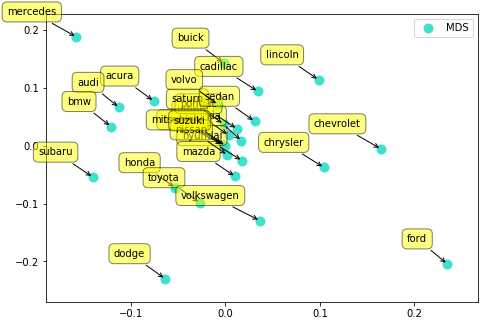

In [72]:
fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')

plt.legend(scatterpoints=1, loc='best', shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0

# Plot the edges
start_idx, end_idx = np.where(pos)

values = np.abs(similarities)

for label, x, y in zip(unique_brands, pos[:, 0], pos[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

In [32]:
brand_combo_dict[('kia', 'hyundai')]

8

### Do the same thing for top 10 brands by frequency

In [33]:
top_ten_brands = sorted_brands[:10]
top_ten_brands_list = []
for b in top_ten_brands:
    top_ten_brands_list.append(b[0])

#### Create top 10 brand combonations count dictionary

In [34]:
top_ten_brand_combos = []
for i in range (len(top_ten_brands_list)):
    for j in range (len(top_ten_brands_list)):
        brand_combo = (top_ten_brands_list[i], top_ten_brands_list[j])
        top_ten_brand_combos.append(brand_combo)

In [35]:
top_ten_brand_combo_dict = {}
for bc in top_ten_brand_combos:
    top_ten_brand_combo_dict[bc] = 0

In [36]:
for bc in top_ten_brand_combos:
    for c in comments:
        brand1 = bc[0]
        brand2 = bc[1]
        if brand1 in c and brand2 in c:
            top_ten_brand_combo_dict[bc] += 1

#### Create top 10 brand count dictionary

In [37]:
top_ten_brands_dict = {}
for b in top_ten_brands_list:
    for c in comments:
        if b in c:
            if b in top_ten_brands_dict:
                top_ten_brands_dict[b] += 1
            else:
                top_ten_brands_dict[b] = 1

#### Calculate lift for top 10 brands

In [38]:
# tot_number_of_comments
# top_ten_brands_dict
# top_ten_brand_combo_dict

top_ten_brand_combo_lifts_dict = {}
for bc in top_ten_brand_combo_dict:
    if bc[0] == bc[1]:
        lift = 0
    else:
        combo_count = top_ten_brand_combo_dict[bc]
        brand1_count = top_ten_brands_dict[bc[0]]
        brand2_count = top_ten_brands_dict[bc[1]]
        lift = (tot_number_of_comments * combo_count) / (brand1_count * brand2_count)
    top_ten_brand_combo_lifts_dict[bc] = lift

#### Matrix

In [39]:
top_ten_matrix = []
row = -1
current_brand = ''
for combo in top_ten_brand_combo_lifts_dict:
    brand = combo[0]
    lift = top_ten_brand_combo_lifts_dict[combo]
    if brand == current_brand:
        top_ten_matrix[row].append(lift)
    else:
        row += 1
        current_brand = brand
        top_ten_matrix.append([])
        top_ten_matrix[row].append(lift)

In [61]:
for i in range (len(top_ten_matrix)):
    for j in range (len(top_ten_matrix[i])):
        if top_ten_matrix[i][j] != 0:
            top_ten_matrix[i][j] = 1/top_ten_matrix[i][j]

In [66]:
d_similarities = pd.DataFrame(top_ten_matrix, columns=top_ten_brands_list, index=top_ten_brands_list)

In [67]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(d_similarities).embedding_

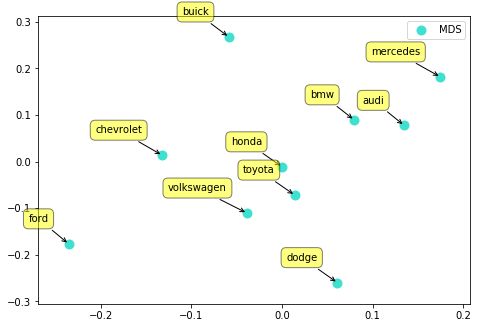

In [68]:
fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')

plt.legend(scatterpoints=1, loc='best', shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0

# Plot the edges
start_idx, end_idx = np.where(pos)

values = np.abs(similarities)

for label, x, y in zip(top_ten_brands_list, pos[:, 0], pos[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

In [59]:
top_ten_brand_combo_lifts_dict[('dodge', 'ford')]

3.87061310782241